# 1. Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls -la "/content/drive/MyDrive/darknet2"

ls: cannot access '/content/drive/MyDrive/darknet2': No such file or directory
total 32
drwx------ 2 root root 4096 Feb 24 01:38 backup
drwx------ 2 root root 4096 Feb 24 01:38 bin
drwx------ 2 root root 4096 Feb 24 01:38 cfg
drwx------ 2 root root 4096 Feb 24 01:39 cuDNN
drwx------ 2 root root 4096 Feb 24 01:27 custom
drwx------ 2 root root 4096 Feb 24 01:39 data
drwx------ 2 root root 4096 Feb 24 01:27 .ipynb_checkpoints
drwx------ 2 root root 4096 Feb 24 01:38 weights


# 2. Install CUDA related modules, cuDNN

Unzip the cuDNN from Google Drive to Colab /usr/local/cuda folder

In [5]:
!tar -xzvf /content/drive/MyDrive/darknet2/cuDNN/cudnn-10.1-linux-x64-v7.6.5.32.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.6.5
cuda/lib64/libcudnn_static.a
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 6
#define CUDNN_PATCHLEVEL 5
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


## 3. Load DarkNet

- 클라우드에 darknet 폴더가 존재하지 않으면 darknet폴더 생성
- 하위에 backup폴더가 없으면 darknet/backup 폴더 생성

In [6]:
import os
if not os.path.exists('darknet2'):
    os.makedirs('darknet2')
%cd darknet2
os.makedirs('backup')
%ls

/content/darknet2
backup/


In [7]:
!ls -la '/content/drive/MyDrive/darknet2/bin/darknet'

!cp /content/drive/MyDrive/darknet2/bin/darknet ./darknet

!chmod +x ./darknet

-rw------- 1 root root 3213624 Dec 22  2020 /content/drive/MyDrive/darknet2/bin/darknet


In [8]:
!cp -ar '/content/drive/MyDrive/darknet2/data' .

- 사용할 함수 정의

In [9]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  
  
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

      
def download(path):
  from google.colab import files
  files.download(path)

# 5. Custom Yolo

- /drive/MyDrive/darknet/custom/ 폴더 안의 내용을 /darknet/coustom/ 폴더로 복사

In [11]:
!cp -r "/content/drive/MyDrive/darknet2/custom" .

In [10]:
#label없는 jpg파일때문에 오류 발생 방지
import os
from glob import glob
from sklearn.model_selection import train_test_split
txt_list = glob('/content/drive/MyDrive/darknet2/custom/*.txt')
img_list = glob('/content/drive/MyDrive/darknet2/custom/*.jpg')
#txt파일과 jpg파일이 둘다 존재해야 data_list에 추가함-> train_test_split함수로 쪼개서 txt파일로 저장
data_list=[] 
len(img_list)  
for i in img_list:
  for j in txt_list:
    if i[:-4] == j[:-4]:
      data_list.append(i)
train_img_list, test_img_list = train_test_split(data_list, test_size=0.1, random_state=20)
print(len(train_img_list),len(test_img_list))

with open('/content/drive/My Drive/darknet2/custom/train.txt','w') as f:
  f.write('\n'.join(train_img_list)+'\n')
with open('/content/drive/My Drive/darknet2/custom/test.txt','w') as f:
  f.write('\n'.join(test_img_list)+'\n')

86 10


# 학습


In [10]:
!./darknet detector train custom/teeth.data custom/yolov3.cfg custom/darknet53.conv.74 -dont_show 

^C


# 학습점검

In [ ]:
if os.path.exists('./backup'):
    !cp -r ./backup "/content/drive/MyDrive/darknet2"  

if not os.path.exists('./backup'):
    os.makedirs('./backup')
    !cp -r "/content/drive/MyDrive/darknet2/backup/yolov3_final.weights" ./backup

In [ ]:
!cp -r "/content/drive/MyDrive/darknet2/backup/yolov3_final.weights" ./backup

In [12]:
!./darknet detector map custom/teeth.data custom/yolov3.cfg backup/yolov3_last.weights

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

In [12]:
!./darknet detector map custom/teeth.data custom/yolov3.cfg backup/yolov3_final.weights

CUDA status Error: file: ./src/dark_cuda.c : () : line: 36 : build time: Dec 22 2020 - 21:35:07 
CUDA Error: no CUDA-capable device is detected
CUDA Error: no CUDA-capable device is detected: Bad file descriptor
darknet: ./src/utils.c:293: error: Assertion `0' failed.


In [ ]:
!./darknet detector map custom/teeth.data custom/yolov3.cfg backup/yolov3_4000.weights

In [ ]:
!./darknet detector map custom/teeth.data custom/yolov3.cfg backup/yolov3_3000.weights

In [ ]:
!./darknet detector map custom/teeth.data custom/yolov3.cfg backup/yolov3_2000.weights

In [ ]:
!./darknet detector map custom/teeth.data custom/yolov3.cfg backup/yolov3_1000.weights

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

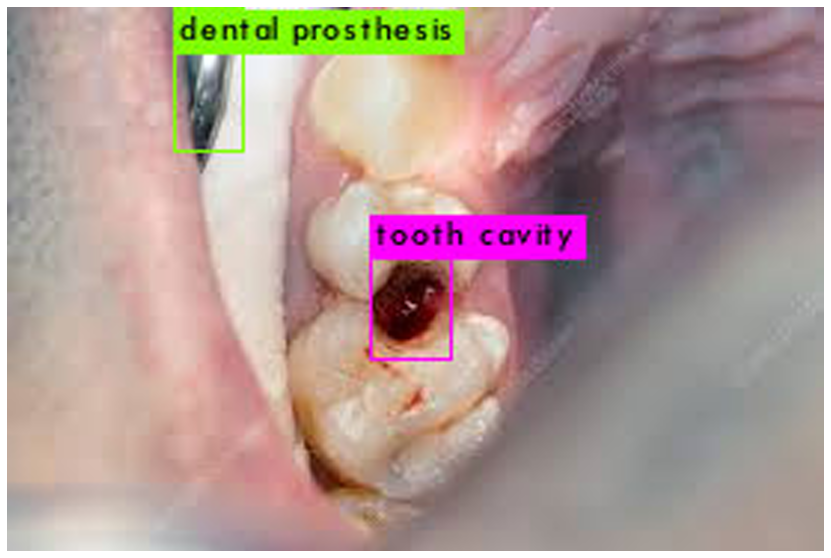

In [23]:
!./darknet detector test custom/teeth.data custom/yolov3.cfg  backup/yolov3_final.weights custom/22.jpg -dont-show
imShow('predictions.jpg')